# This Notebook explores the SCAR GeoMAP dataset released in 2019
## Cox S.C., Smith Lyttle B. and the GeoMAP team (2019). Lower Hutt, New Zealand. GNS Science. Release v.201907.
### [Data Available Here](https://data.gns.cri.nz/ata_geomap/index.html?content=/mapservice/Content/antarctica/www/index.html)

### Notebook by Sam Elkind

Initially, I'll look at the data in terms of polygon counts. This section will be focused on examining the data schema and frequency of values occurring within specific fields. This investigation will focus on finding inconsistencies in the data attribution, but also could stimulate some discussion regarding relationships between columns.

Next, I'll look at the data in terms of polygon area and data attribution. How much surface water has been mapped? How much till has been mapped? How much outcropping rock is of Jurassic age?

### Configure packages, paths, and load data

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pprint as pp
from tabulate import tabulate

In [26]:
def plot_value_counts(field_name, values_to_plot, counts, counts_norm):
    fig, ax = plt.subplots(2, 1, figsize=(30,15))
    fig.tight_layout(pad=2.0)
    fig.subplots_adjust(top=.94)
    fig.suptitle(f"Frequency of {field_name} values", size=18)

    ax[0].set_title(field_name)
    ax[1].set_title(f"{field_name} normalized")
    for i, v in enumerate(counts[:values_to_plot]):
        ax[0].text(i - .5, v, str(v), color='black', fontweight='bold')
    for i, v in enumerate(counts_norm[:values_to_plot]):
        ax[1].text(i - .5, v, f"{str(v * 100)[:3]}%", color='black', fontweight='bold')
    ax[0].bar(counts.index[:values_to_plot], counts[:values_to_plot])
    ax[1].bar(counts_norm.index[:values_to_plot], counts_norm[:values_to_plot])

In [2]:
geol_path = f"{os.getcwd()}/data/ATA_SCAR_GeoMAP_geology.gdb"
print(geol_path)

/home/sam/geomap/data/ATA_SCAR_GeoMAP_geology.gdb


In [3]:
data = gpd.read_file(geol_path)

## What can we learn just from looking at the number of unique values for each attribute?

In [4]:
nunique_cols = pd.DataFrame(data.nunique())
display(nunique_cols)

,0
SOURCECODE,801
MAPSYMBOL,173
PLOTSYMBOL,183
NAME,666
DESCR,757
POLYGTYPE,3
MBREQUIV,19
FMNEQUIV,246
SBGRPEQUIV,1
GRPEQUIV,59


### Discussion of unique column values

- 95,128 total polys
- 801 original source units have been compressed into 183 units based on the Chronostratigraphic Legend
- My understanding of MAPSYMBOL AND PLOTSYMBOL was that they were pretty much equivalent. Is there a good reason for the fact that they have a different number of unique values?
- Interestingly, there are more SOURCECODE values than NAMEs. It could be important to look into records that have the same NAME, but distinct SOURCECODEs.
- I would also imagine that each named unit should have a single description. Because the DESC field is a longer string, I suspect that there are formatting inconsistencies.
- POLYGTYPE will be a very good column to group by when doing descriptive statistics.
- SUBGRPEQUIV has only one value, is it worth including in the schema?
- There are 12 STRATRANKS, should there be a column for each of them, should the values be normalized to fit within existing EQUIV columns?
- 6 TYPENAME values but only 5 TYPE_URIs.
- LITHCODE and REPLITH_URI may need the same number of values, although those columns may not need to be deterministically related
- LITHOLOGY may need some formatting to reduce the number of unique values.
- CONFIDENCE has 162 unique values. It may be valuable to normalize the values in this field into broader categories, resulting in fewer values
- 152 Sources, It would be interesting to look at citation numbers of each source and possibly rank sources for each DATASET
- SYMBOL seems to be an unused column
- How formal are the Dataset areas? Can we draw well-defined footprints on a continent scale map for them?
- why do some geometries not have Shape_Lengths and areas. Do these need to be recalculated to be included in the next release?


# Let's investigate SOURCECODE values

In [5]:
counts = data["SOURCECODE"].value_counts(ascending=False)
norm_counts = data["SOURCECODE"].value_counts(ascending=False, normalize=True)

In [6]:
print(counts.max)

<bound method Series.max of C-Tr          4479
Rb            3479
Mv            3445
?4            2986
?6            2917
              ... 
G8               1
Hv_Cl301_3       1
Bgu              1
Pgb              1
Pgd              1
Name: SOURCECODE, Length: 801, dtype: int64>


## There are too many unique values to cleanly display in a list or a graph. Let's look at a histogram of the whole set of unique values and then look at the top end and bottom end.

### Let's begin with a cumulative frequency plot that shows the distribution of source code frequencies

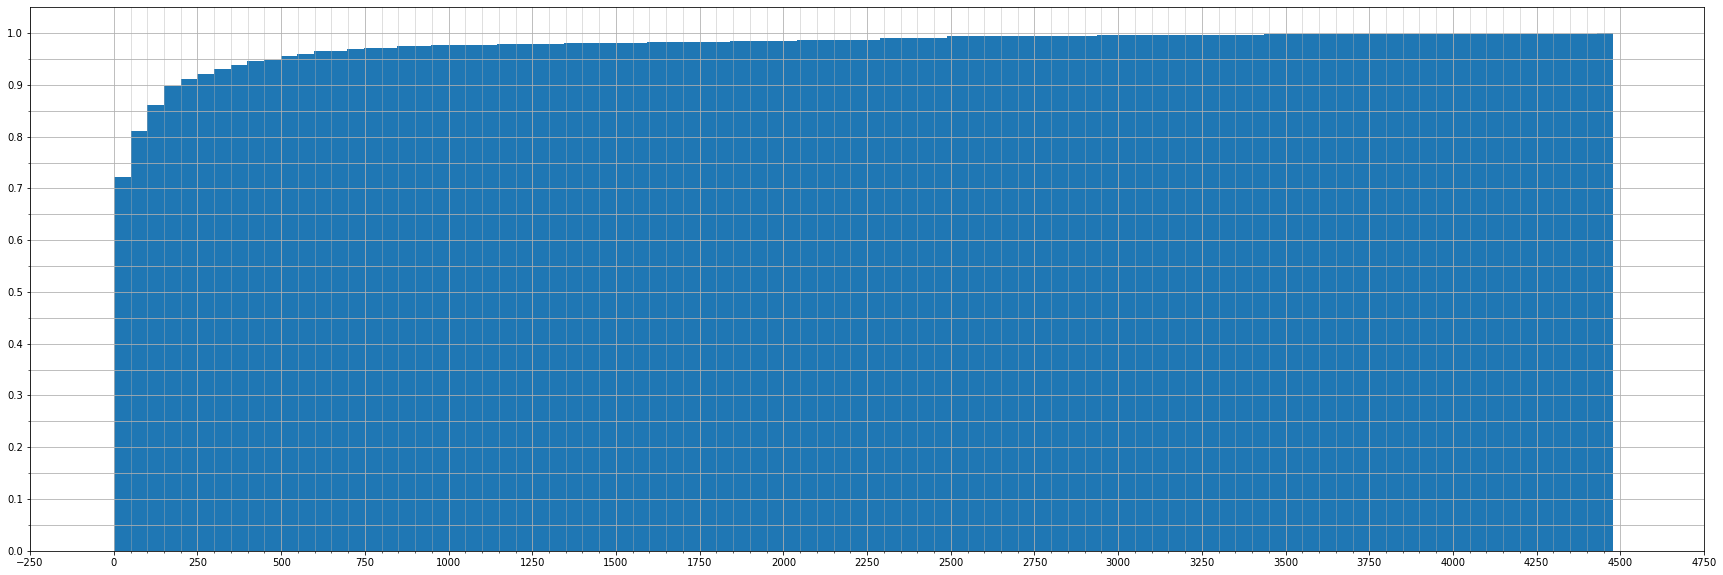

In [7]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

counts_hist = counts.hist(cumulative=True, density=1, bins=90, ax=ax, histtype="bar")
minor_x_ticks = np.arange(0, 4500, 50)
major_x_ticks = np.arange(-250, 5000, 250)
ax.set_xticks(major_x_ticks, minor=False)
ax.set_xticks(minor_x_ticks, minor=True)
ax.xaxis.grid(True, which='minor', alpha=0.5)

major_y_ticks = np.arange(0, 1.1, 0.1)
minor_y_ticks = np.arange(0, 1, 0.05)
ax.set_yticks(major_y_ticks, minor=False)
ax.set_yticks(minor_y_ticks, minor=True)
ax.yaxis.grid(True, which='minor')

#### The range of code frequencies is roughly {1, 4500}, thus with 90 bins we get bins with that represent roughly 50 values each.
- over 70% of source codes have 50 or fewer occurrences. It may be interesting to look at a cumulative frequency plot or histogram of just that bin.
- over 80% of source codes have 100 or fewer occurrences. 
- 90% of source codes have 200 or fewer occurences. Above 200 occurrences, the frequency of codes drops off exponentially.
- Because of this exponential drop in code frequency towards the upper end, plotting that end of the distribution in a bar graph may yield some interpretable information

### What does a bar graph tells us about the top 50 most frequently occurring values?

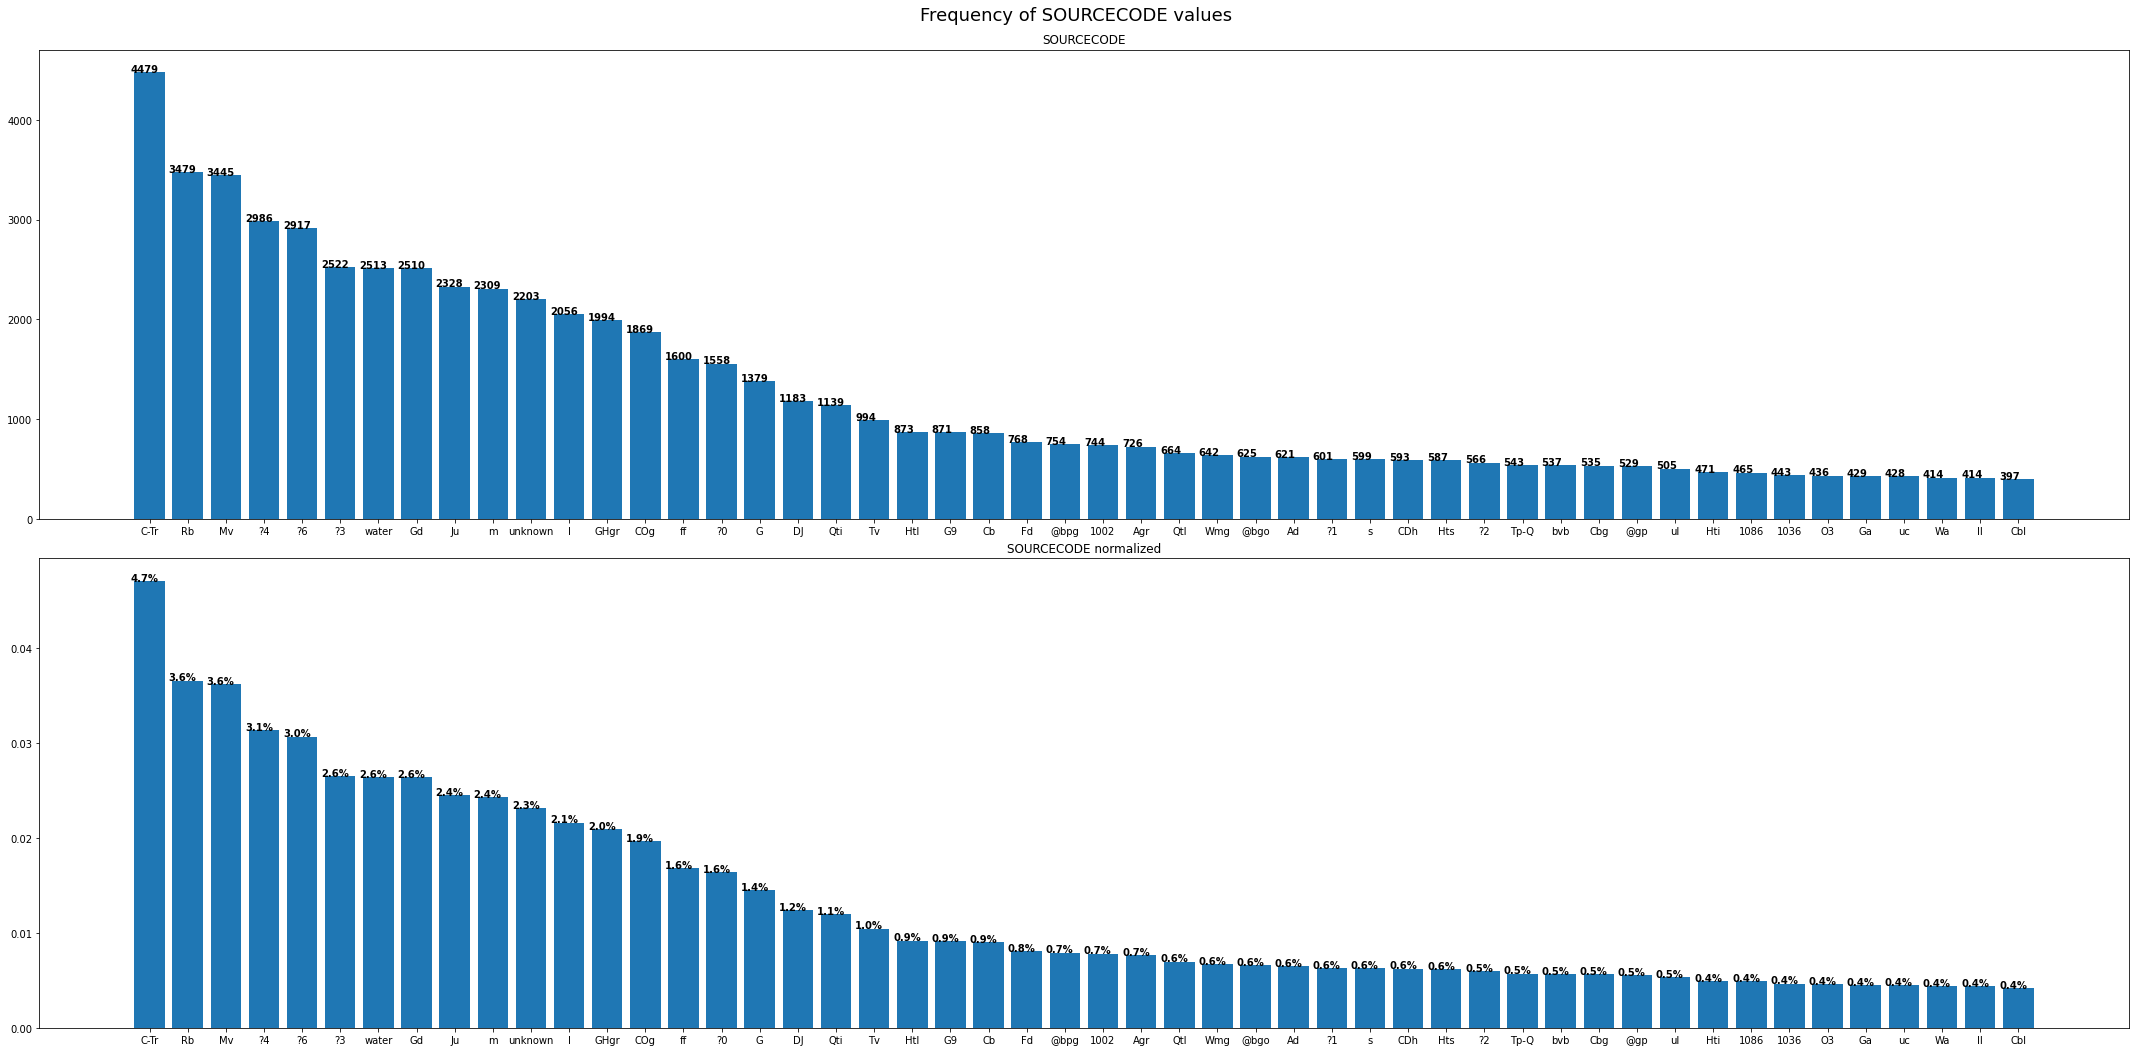

In [28]:
plot_value_counts("SOURCECODE", 50, counts, norm_counts)

#### Discusion of frequently occuring codes:
- Unknown observations jump out as the 11th most frequently occuring code. 
- There are several frequently occurring codes that are simply 2-digit numbers. It may be the case that these numbers are displayed on the map, but are codes for legend entries in the source that have a alphabetic code for the rock unit. Including or converting to these alphabetic codes from the source may be out of scope for the SOURCECODE field. Need to look up the description of this field for clarification.
- If I want to dive down a rabbit hole I could try to group the codes by format (2-letter codes, 3-letter codes, 2-digit numbers, codes with "@" prefix, etc) and see if there are correlations with the source or the background of the source creator.


### Since "unknown" is a string, let's see if there were other values that are just typeos or abbreviations of "unknown" in this set of values.

In [9]:
print("number of 'unkown' polys:", counts["unknown"])
unknown_alts = [i for i in counts.index if "un" in i.lower()] 
print("Unknown alternatives:")
for i in unknown_alts:
    print(f"SOURCECODE: {i}, polygons: {counts[i]}")

number of 'unkown' polys: 2203
Unknown alternatives:
SOURCECODE: unknown, polygons: 2203
SOURCECODE: unk, polygons: 111


There's one other source code appearing that is literally "unk". It might be useful to look at the sources of these to see if the code is shorthand for unknown and should be corrected, or is actually a mapped unit.

#### Following up on unknowns, the question mark was used to indicate uncertainty in the classification. There are 38 SOURCECODES with question marks and these represent nearly 12,000 polygons

In [10]:
question_marks = [i for i in counts.index if "?" in i]
print(f"SOURCECODEs with '?' ({counts[question_marks].sum()} in total)")
print()
for i in question_marks:
    print(f"SOURCECODE: {i}, polygons: {counts[i]}")

SOURCECODEs with '?' (11941 in total)

SOURCECODE: ?4, polygons: 2986
SOURCECODE: ?6, polygons: 2917
SOURCECODE: ?3, polygons: 2522
SOURCECODE: ?0, polygons: 1558
SOURCECODE: ?1, polygons: 601
SOURCECODE: ?2, polygons: 566
SOURCECODE: ?5, polygons: 339
SOURCECODE: g?, polygons: 63
SOURCECODE: ff?, polygons: 61
SOURCECODE: Mv?, polygons: 47
SOURCECODE: ?, polygons: 38
SOURCECODE: mv?, polygons: 29
SOURCECODE: ut?, polygons: 28
SOURCECODE: Cb?, polygons: 28
SOURCECODE: ?7, polygons: 24
SOURCECODE: bt?, polygons: 17
SOURCECODE: mvb?, polygons: 15
SOURCECODE: ul?, polygons: 12
SOURCECODE: grb?, polygons: 11
SOURCECODE: s?, polygons: 10
SOURCECODE: gam?, polygons: 9
SOURCECODE: fm?, polygons: 7
SOURCECODE: gaa?, polygons: 7
SOURCECODE: gg?, polygons: 7
SOURCECODE: Pb_LeM2c1?, polygons: 6
SOURCECODE: sm?, polygons: 5
SOURCECODE: PP?, polygons: 5
SOURCECODE: bv?, polygons: 4
SOURCECODE: gr?, polygons: 3
SOURCECODE: PC-B?, polygons: 3
SOURCECODE: I?, polygons: 2
SOURCECODE: gro?, polygons: 2
S

Reflecting on all of this, while "unkown", "unk", and "?" all indicate an unknown rock classification, correcting these would to a single code would conflict with the intent behind the SOURCECODE field. It will be important, however, to ensure that polygons with these three SOURCECODES have consistent attribution in other lithologically-oriented fields

## Switching gears, Let's take a quick look at the formatting of symbols. For starters, let's look at the distributions of SOURCE CODE lengths

In [11]:
src_code_lengths = pd.DataFrame([int(len(i)) for i in counts.index]).value_counts(ascending=False)

In [12]:
indices = [int(i[0]) for i in src_code_lengths.index]
values = [i for i in src_code_lengths]
sorted_lengths = sorted(list(zip(indices, values)))

In [13]:
sorted_indices, sorted_values = list(zip(*sorted_lengths))

117 values longer than 4 characters


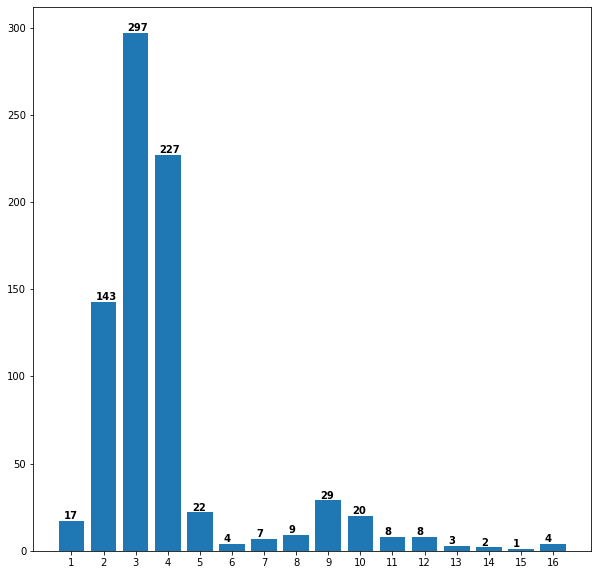

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
x_ticks = np.arange(1, 17, 1)
ax.set_xticks(x_ticks, minor=False)
for i, v in enumerate(sorted_values):
    ax.text(i + .75, v + 1, str(v), color='black', fontweight='bold')
ax.bar(sorted_indices, sorted_values)
print(f"{sum(sorted_values[4:])} values longer than 4 characters")

The vast majority of codes have lengths between 2 and 4 characters. However, a significant number of codes have lengths longer than 5 characters. Let's take a closer look at these.

In [15]:
med_length_vals = [i for i in counts.index if len(i) > 4]
print(f"codes with more than 4 chars: {len(med_length_vals)} ({len(med_length_vals) / counts.shape[0] * 100:.2f}% of codes)")
print(f"number of polys represented by these SOURCECODES: {counts[med_length_vals].sum()} ({counts[med_length_vals].sum() / counts.sum() * 100:.2f}% of polygons)")
print()
print("displaying source codes longer than 10 chars:")
long_values = [i for i in counts.index if len(i) > 10]
pp.pp(long_values)
print("number of polys represented by these SOURCECODES:", counts[long_values].sum())

codes with more than 4 chars: 117 (14.61% of codes)
number of polys represented by these SOURCECODES: 7003 (7.36% of polygons)

displaying source codes longer than 10 chars:
['MP2-3//NP11bv1',
 'MP3-NP1//NP12pr2',
 'MP3-NP1//NP12pr1',
 'Pb_LMB12.3c',
 'MP1-2//NP1fl',
 'MP2-3//NP11bv2',
 'MP3-NP1//Egr2',
 'MP2-3//NP11bv',
 'Pb_LMB14.2b',
 'MP3-NP1//Egr1',
 'Pb_LMB12.3b',
 'Pb_LMB14.2d',
 'Pb_LMB16D.1a',
 'PP-MP1//NP11',
 'Pb_LMB14.2a',
 'Pb_LMB16D.1_ins',
 'Pb_LMB16B.3a',
 'Pb_LMB16A.1a',
 'Pb_LMB12.3a',
 'Pb_LMB14.2c',
 'Pb_LMB16D.1d',
 'MP3-NP1//NP12sc2',
 'Pb_LMB16D.1b',
 'MP3-NP1//NP12sc1',
 'Pb_LMB14.2e',
 'Pb_LMB16D.1c']
number of polys represented by these SOURCECODES: 642


There are 26 codes longer than 10 characters. Inspecting these, the notation they follow  appear (to me) to be sample ids from a study (this will have to be cross checked by looking at the sources). If this is the case, these polys would probably be better labeled with a more generic SOURCECODE.

## What can we learn from looking at the least-represented SOURCECODES?

### As we established above, over 70% of SOURCECODES represent less than 50 polygons each.
#### Let's make a histogram of just this subset.

In [16]:
less_than_50 = counts[counts < 50]

In [17]:
print(less_than_50.max())
print(less_than_50.min())

49
1


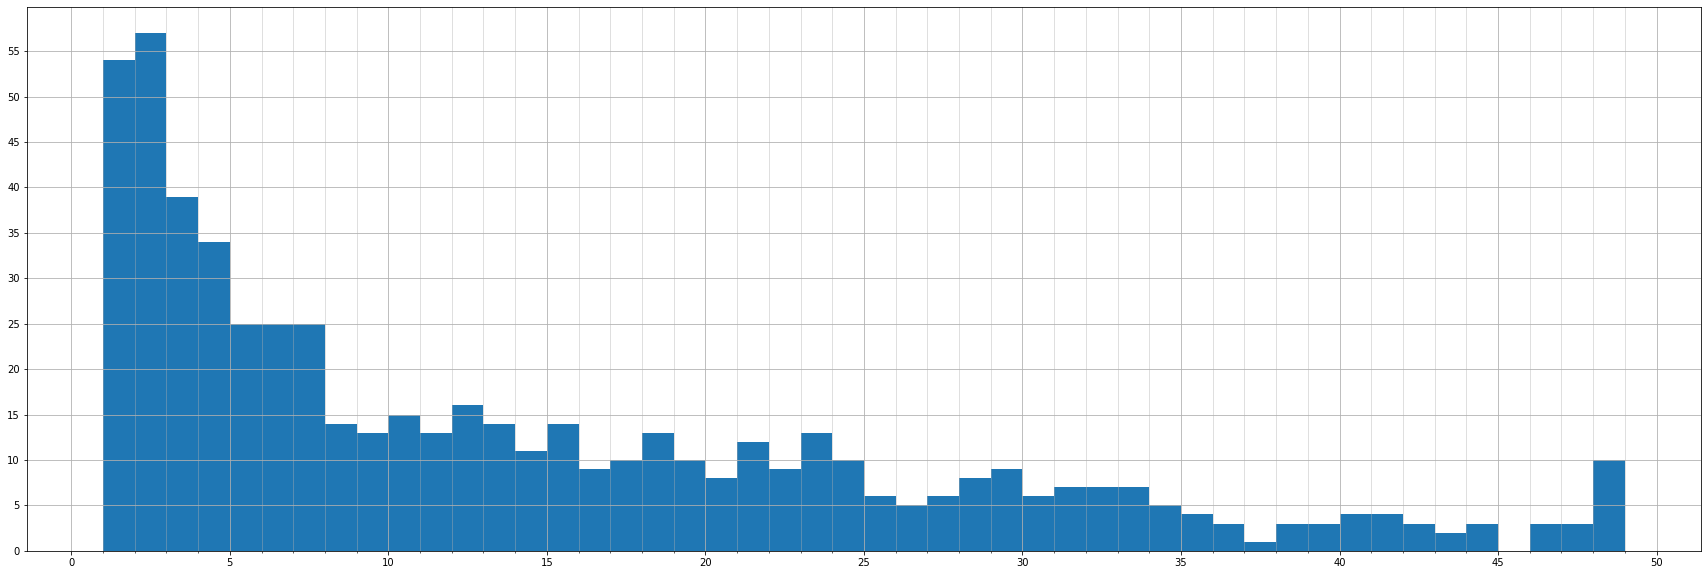

In [18]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

less_than_50_hist = less_than_50.hist(bins=48, ax=ax, histtype="bar")
minor_x_ticks = np.arange(0, less_than_50.max() + 1, 1)
major_x_ticks = np.arange(0, less_than_50.max() + 5, 5)
ax.set_xticks(major_x_ticks, minor=False)
ax.set_xticks(minor_x_ticks, minor=True)
ax.xaxis.grid(True, which='minor', alpha=0.5)

major_y_ticks = np.arange(0, 60, 5)
ax.set_yticks(major_y_ticks)

#### Not a whole lot to see here. It's intuitive that there should be more source codes for polygons that occur less than 5 times. 

How many codes are only applied to a single polygon? 

In [19]:
single_codes = pd.DataFrame(counts[counts <= 1])
print("single codes: ", single_codes.shape[0])

single codes:  54


#### Only 54 codes with a single polygon. That's pretty good.

#### Let's check for potential capitalization errors

In [66]:
lower_codes = [i.lower() for i in counts.index]

In [67]:
print(len(lower_codes))
lower_codes_distinct = set(lower_codes)
print(len(lower_codes_distinct))
cap_error_candidates = pd.DataFrame(lower_codes).value_counts()
print(cap_error_candidates[cap_error_candidates > 1])

801
793
qm     2
g      2
bv     2
mv?    2
mv     2
pcs    2
ocg    2
pp     2
dtype: int64


8 values that are only differentiated by capitalization is great. When they do occur, there is only one variation. This is a small enough set to check sources for these codes to verify whether either or both are correct.

# That seems like more than enough work on SOURCECODE for now. Let's move on to looking at MAPSYMBOL, PLOTSYMBOL and the relationship between them

## There are fewer than 200 values, so let's make bar charts of the top halves and bottom halves of each field

In [22]:
map_sym_counts = data["MAPSYMBOL"].value_counts(ascending=False)
map_sym_counts_norm = data["MAPSYMBOL"].value_counts(ascending=False, normalize=True)
print(map_sym_counts)

JKg    6608
EOg    4707
?      4654
CTw    4479
EOs    4015
       ... 
Czd       2
Dn        2
Et        1
JKj       1
Rzh       1
Name: MAPSYMBOL, Length: 173, dtype: int64


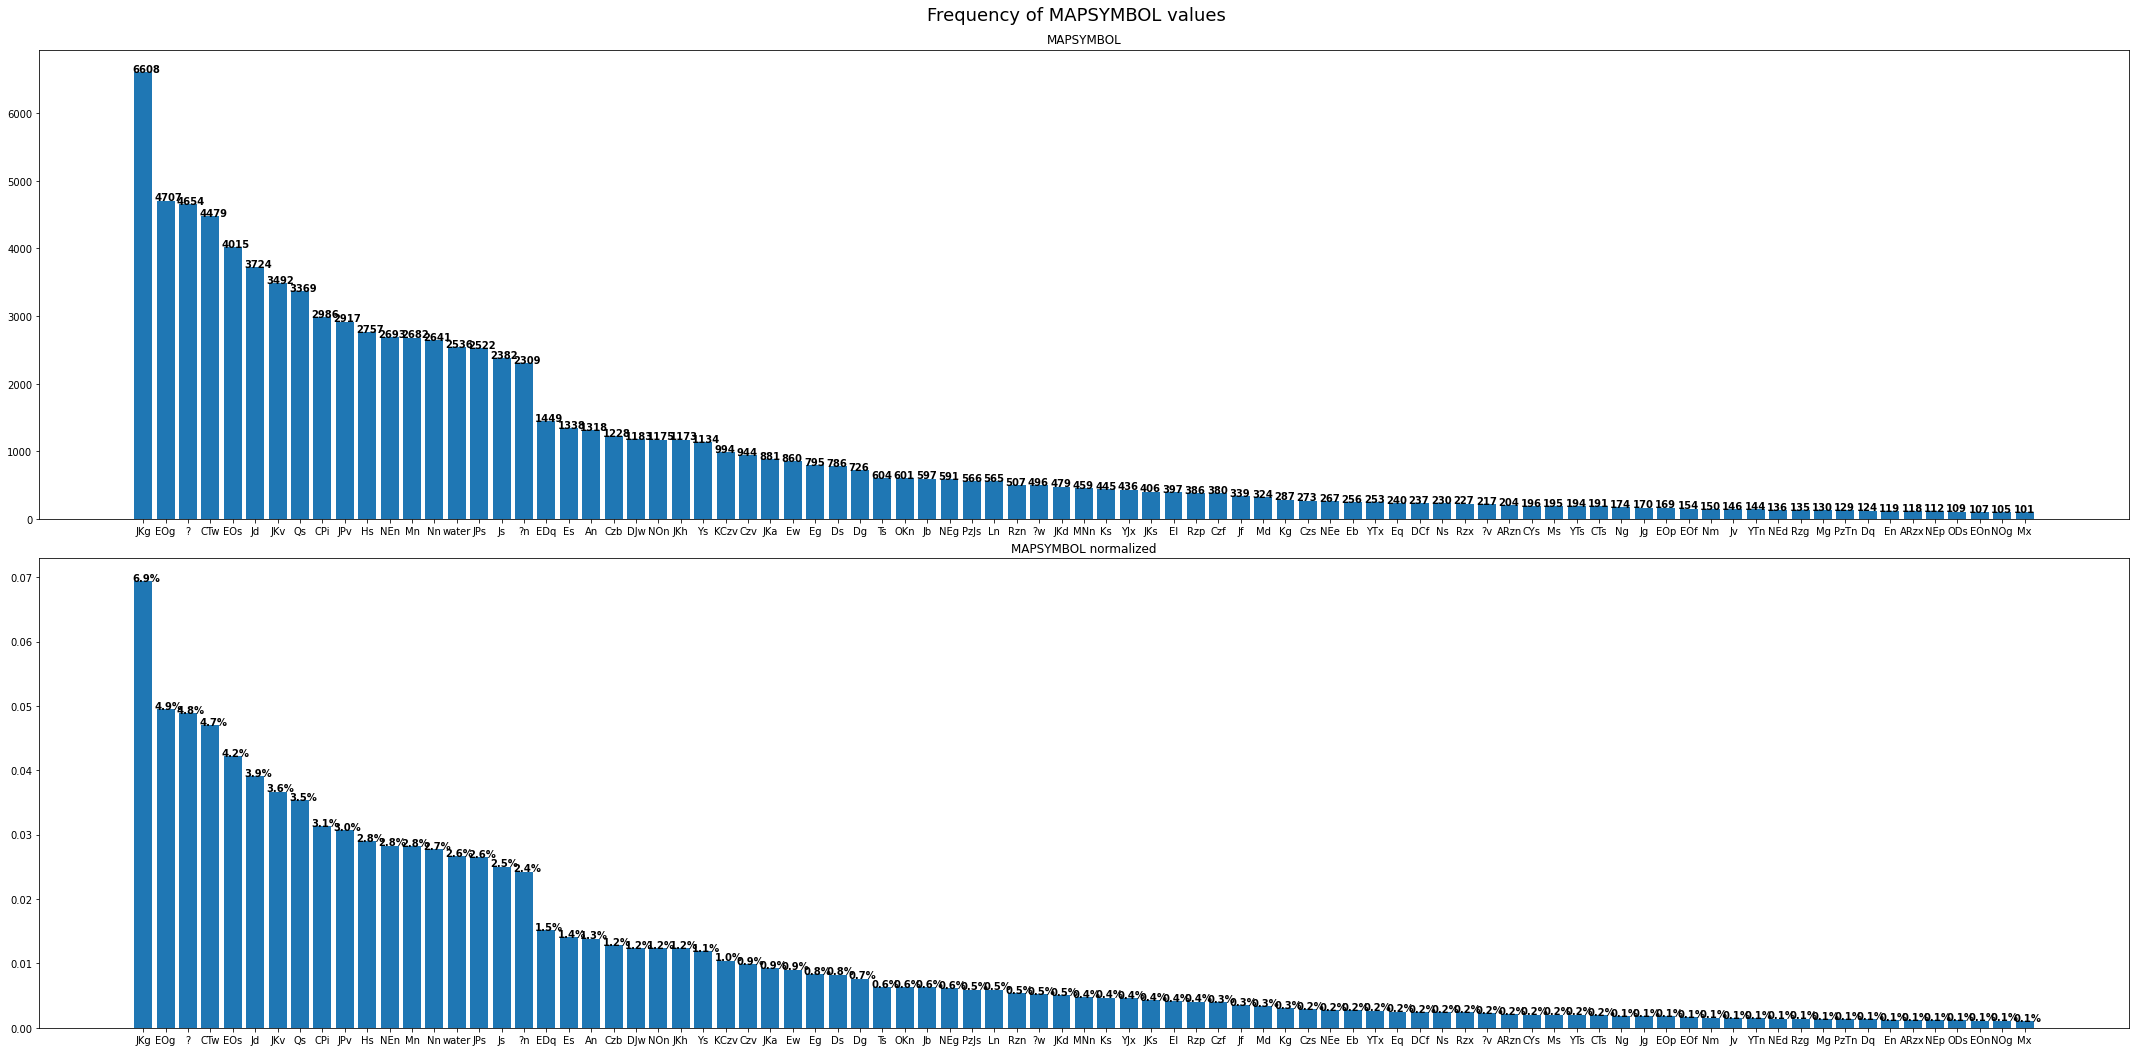

In [27]:
plot_value_counts("MAPSYMBOL", 85, map_sym_counts, map_sym_counts_norm)

In [29]:
plot_sym_counts = data["PLOTSYMBOL"].value_counts(ascending=False)
plot_sym_counts_norm = data["PLOTSYMBOL"].value_counts(ascending=False, normalize=True)

In [31]:
print(plot_sym_counts)

JKg    6608
EOg    4707
?      4654
CTw    4479
EOs    4015
       ... 
Cn        2
Czd       2
Rzh       1
Et        1
JKj       1
Name: PLOTSYMBOL, Length: 183, dtype: int64


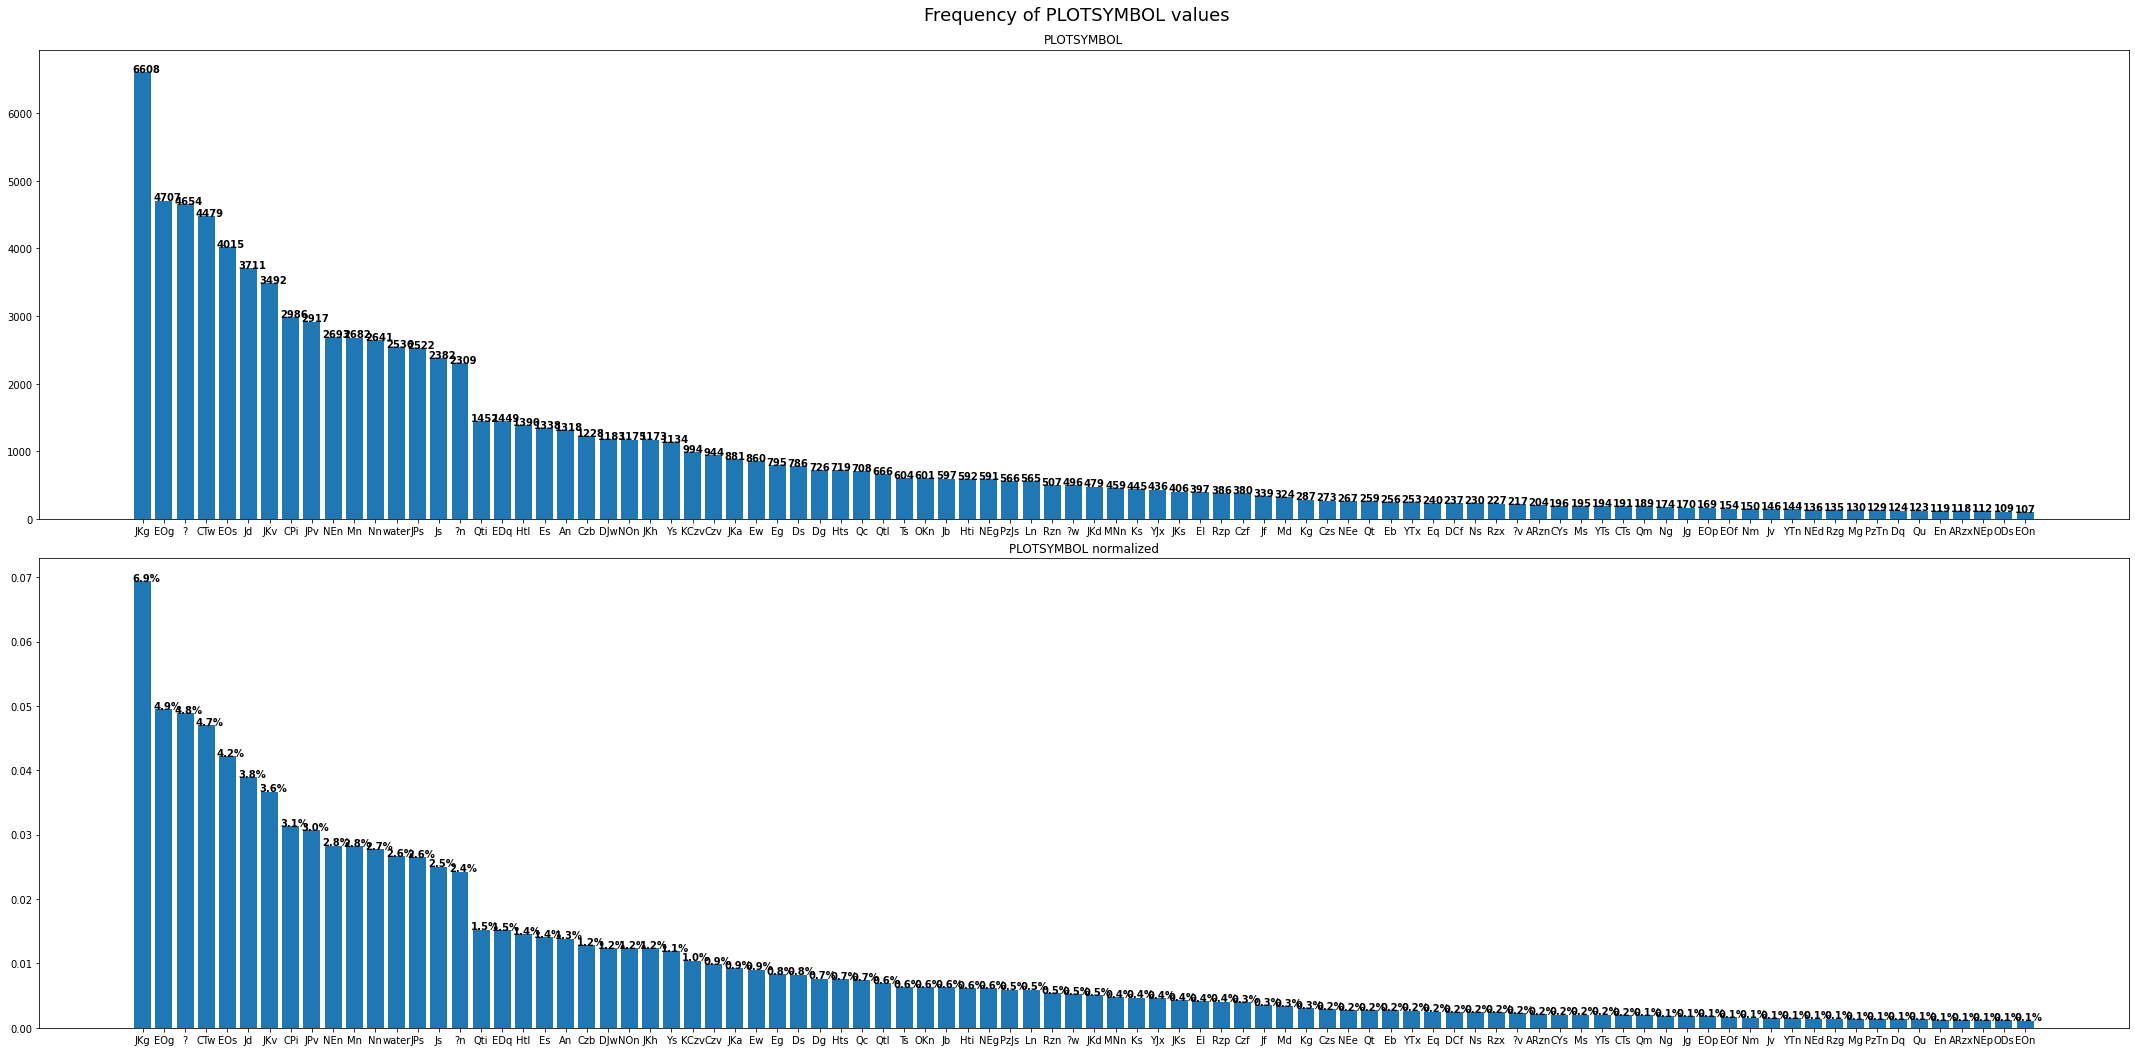

In [30]:
plot_value_counts("PLOTSYMBOL", 90, plot_sym_counts, plot_sym_counts_norm)

## The distribution of these two fields look identical. However, plotsymbol has 10 more values. What explains this discrepancy?

### Let's start by identifying the distinct values.

### Let's look at the 10 most frequently occurring values for several of the columns
Later, it will be more interesting to look at this by area rather than number of polygons

In [159]:
value_count_cols = ["SOURCECODE", "PLOTSYMBOL", "POLYGTYPE", "MBREQUIV", "FMNEQUIV", "GRPEQUIV", "TERREQUIV", "STRATRANK", "TYPENAME", "GEOLHIST", "REPAGE_URI", "AGECODE", "LITHCODE", "REPLITH_URI", "OBSMETHOD", "CONFIDENCE", "SOURCE", "DATASET", "REGION",]
print(len(value_count_cols))
value_counts = [data[i].value_counts(ascending=False) for i in value_count_cols]

19


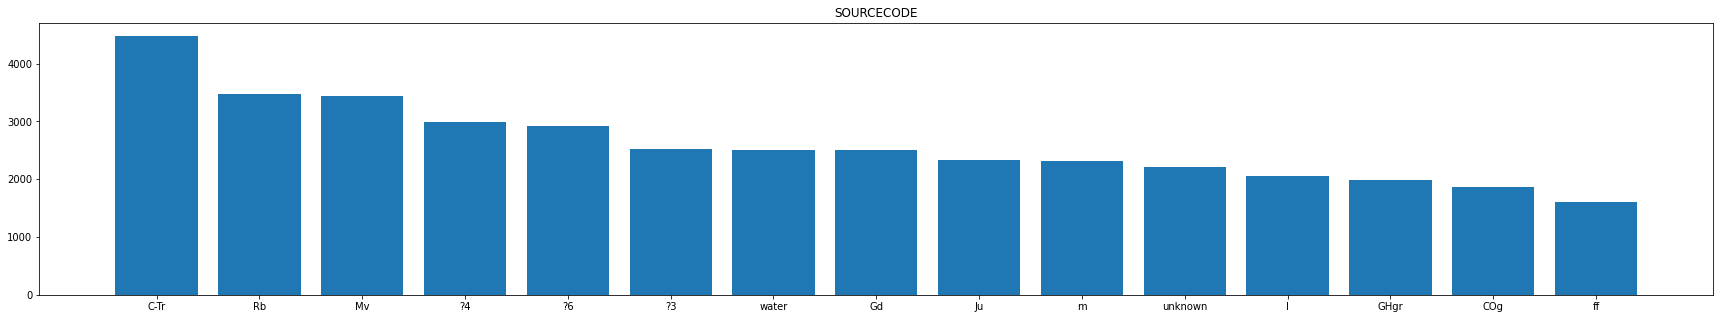

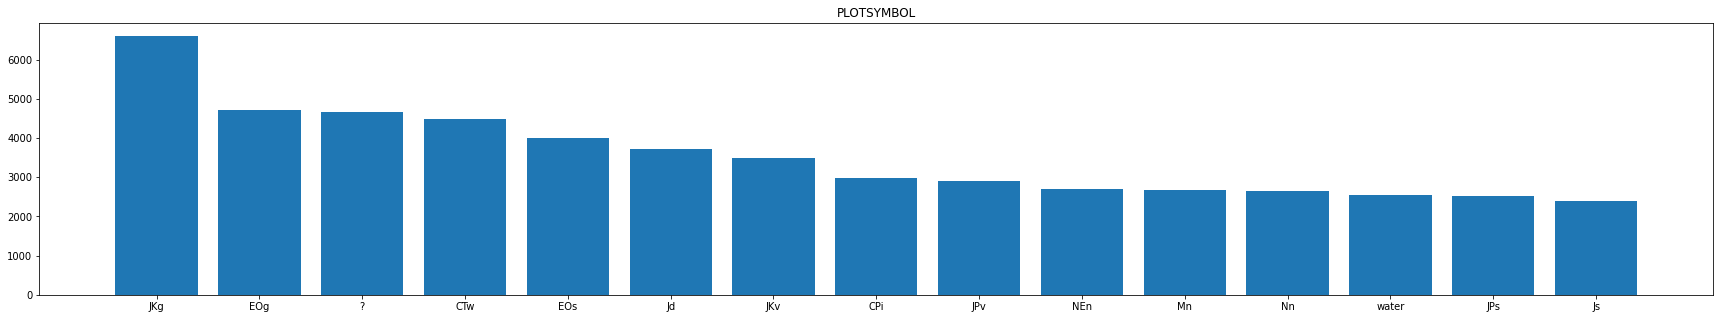

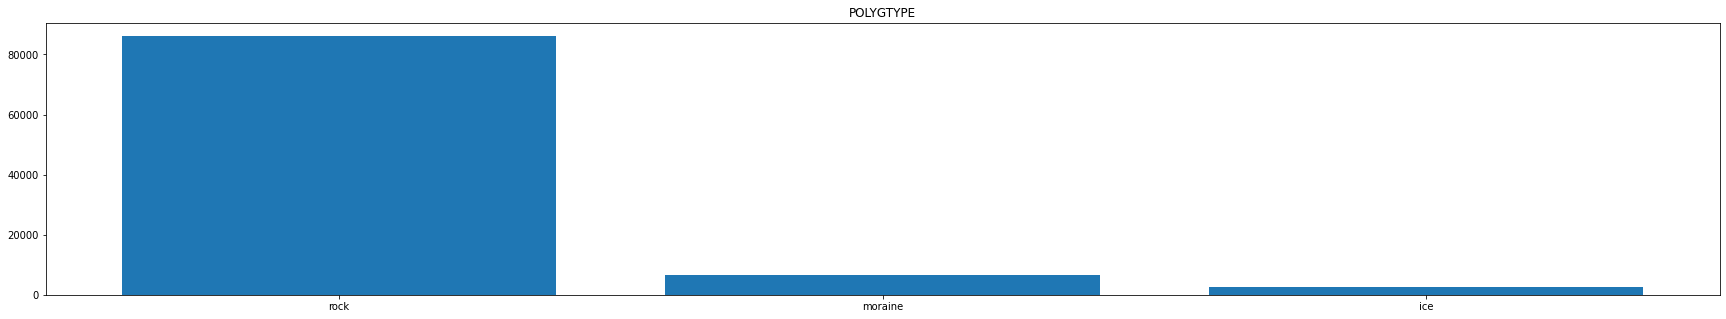

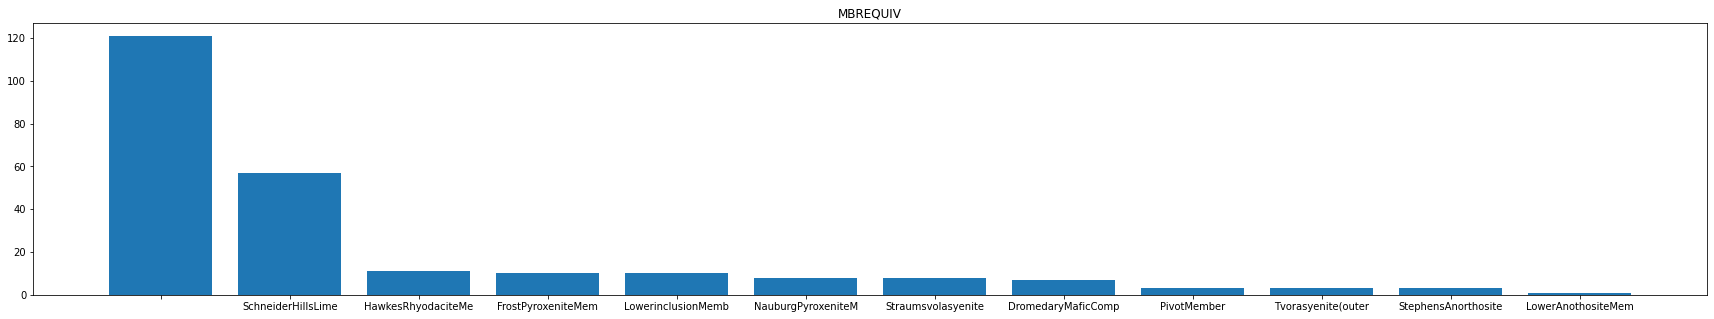

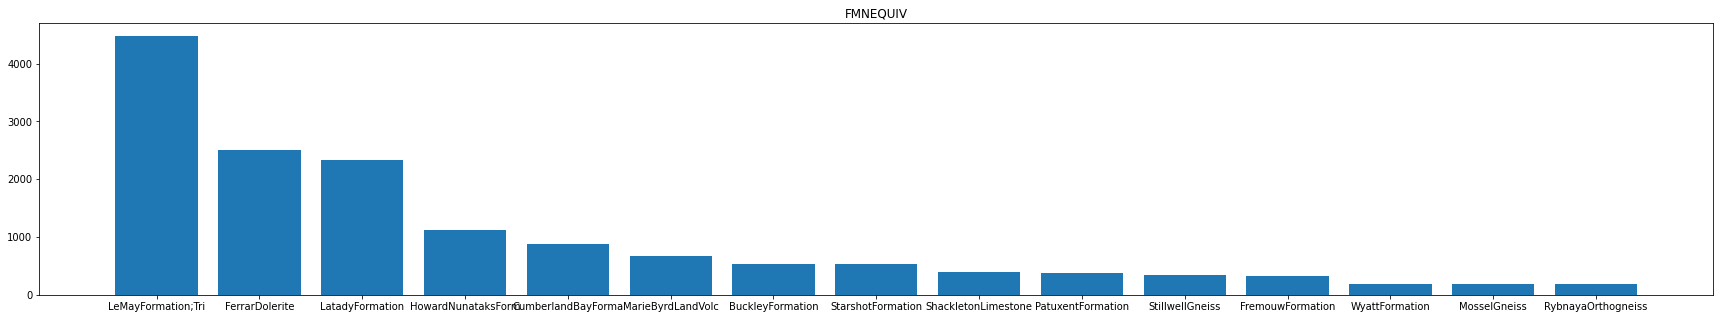

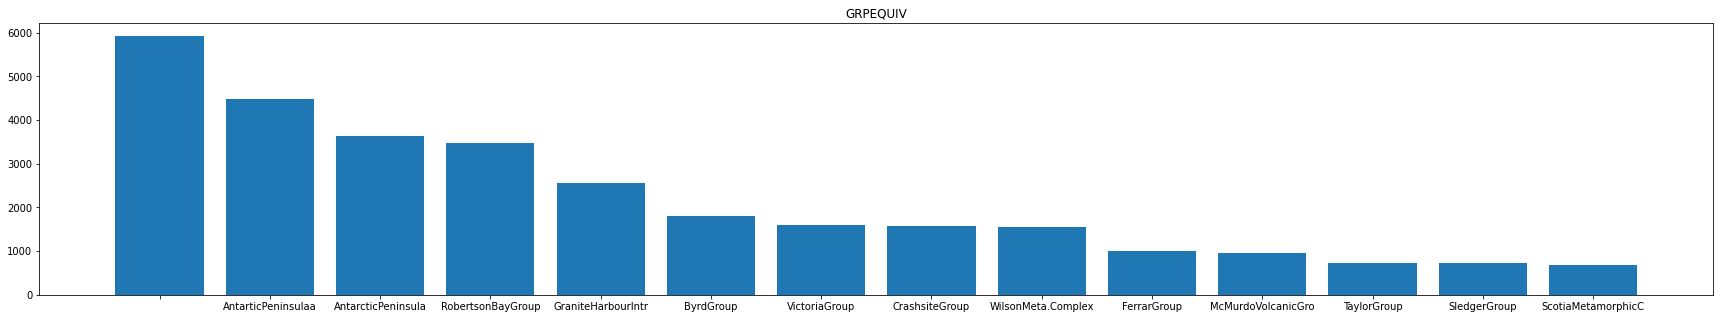

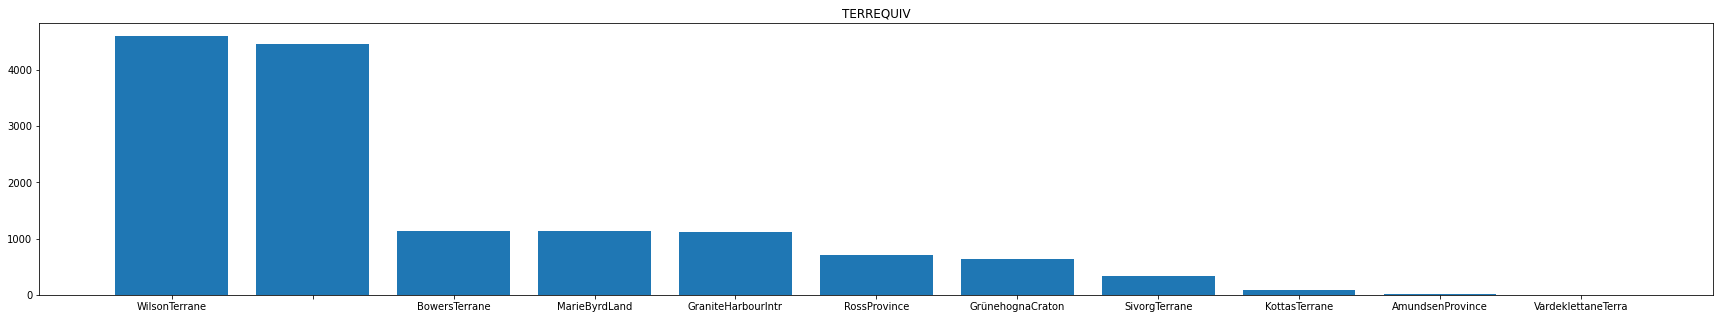

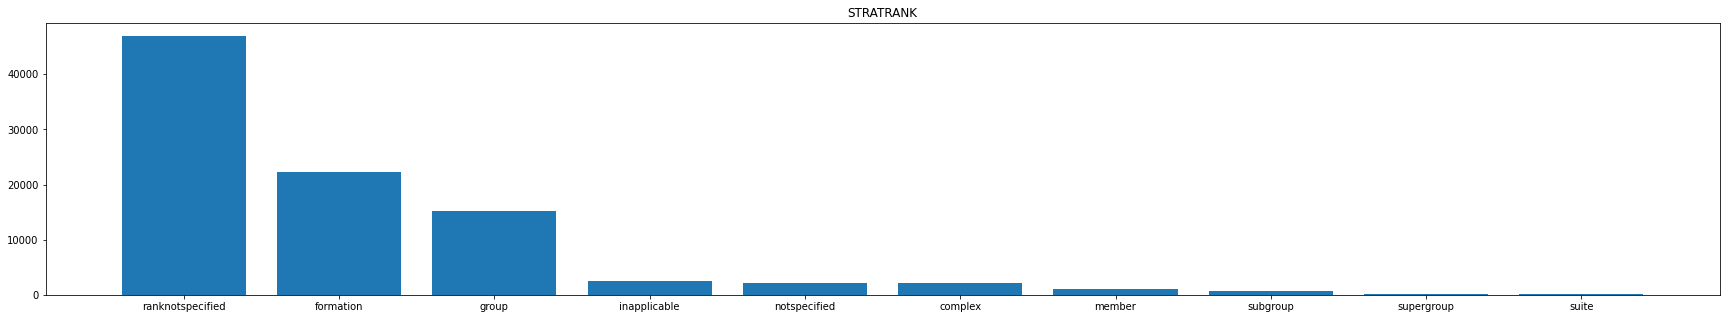

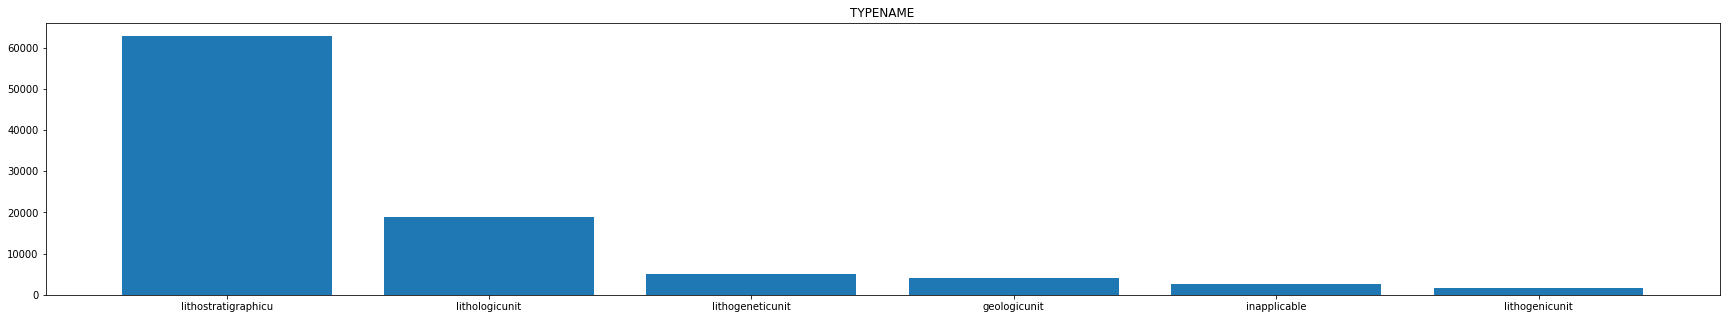

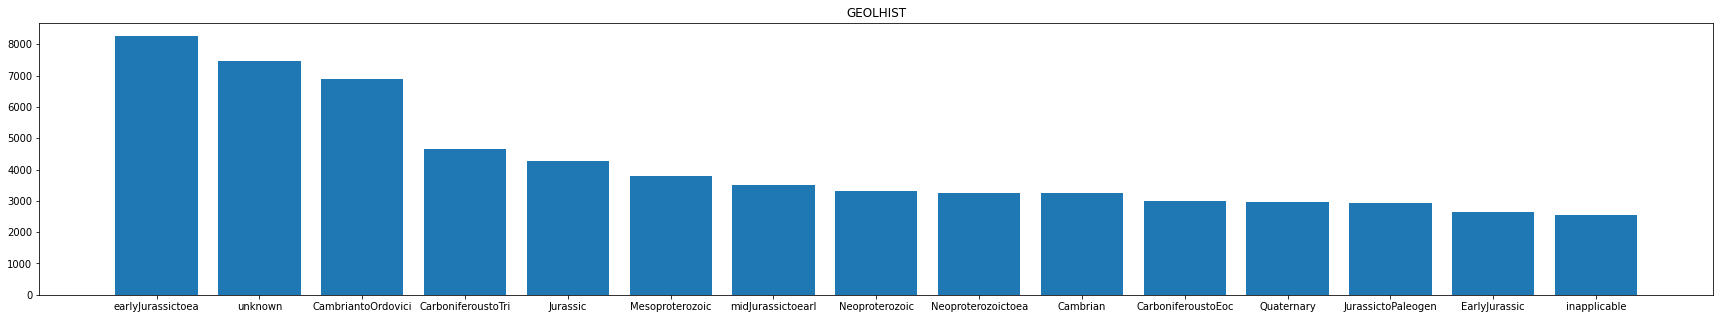

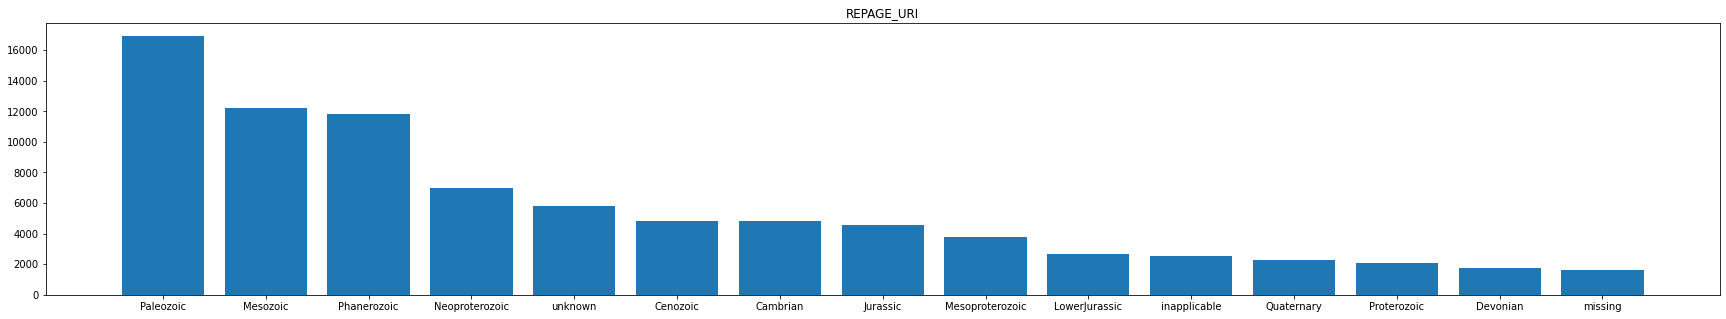

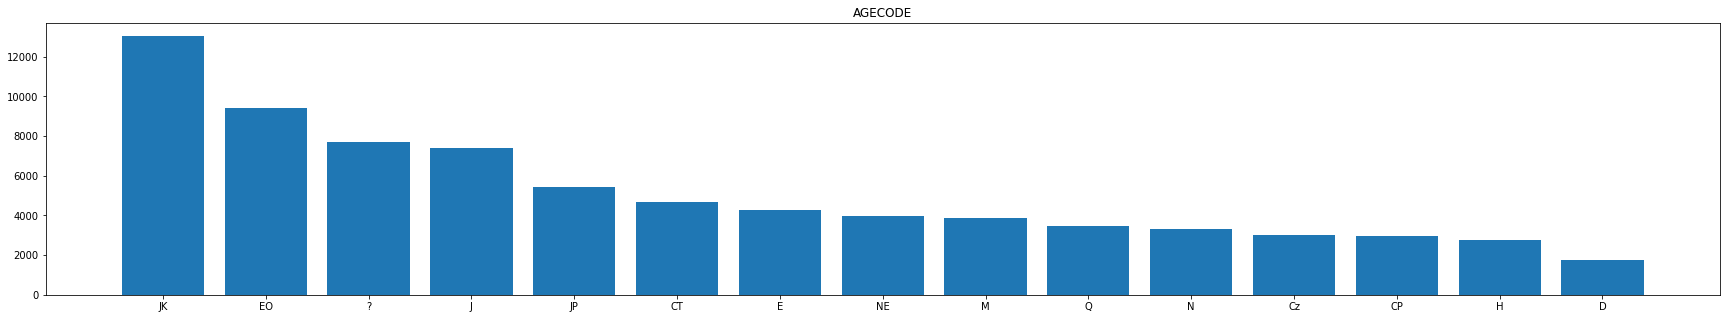

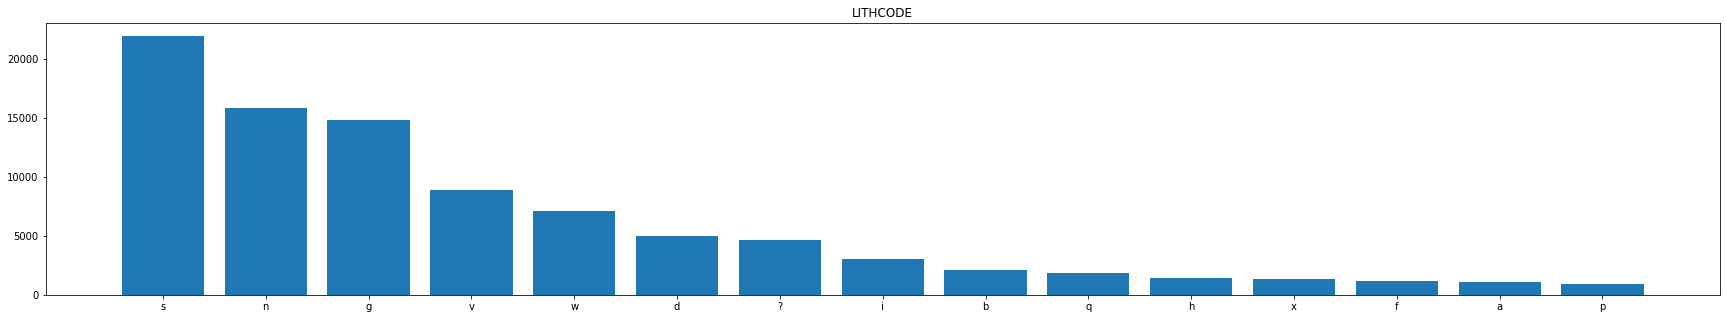

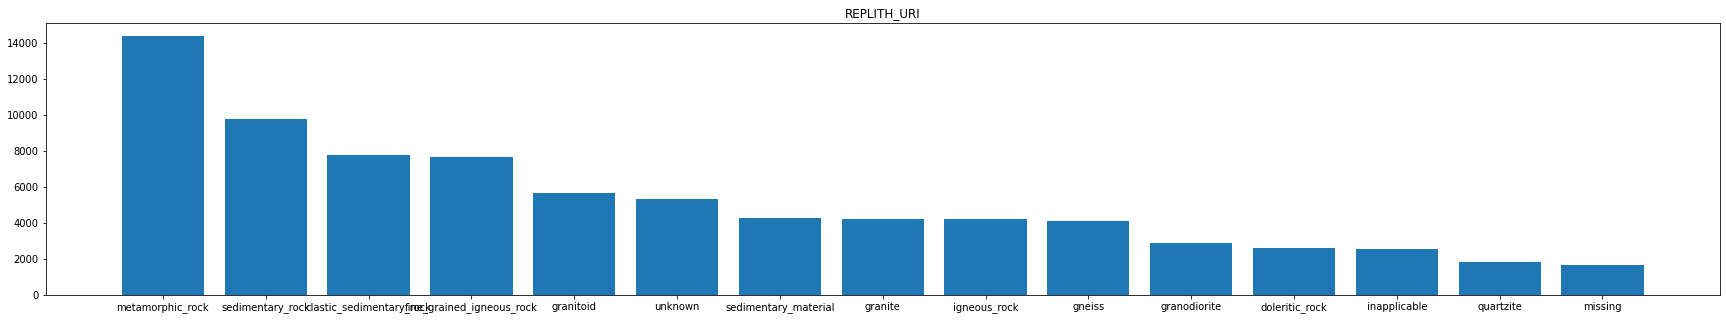

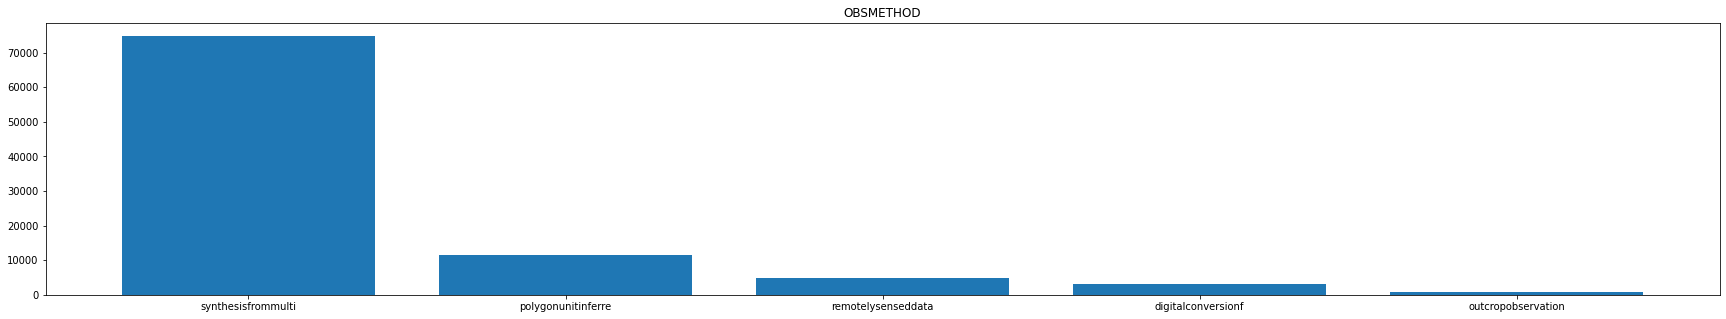

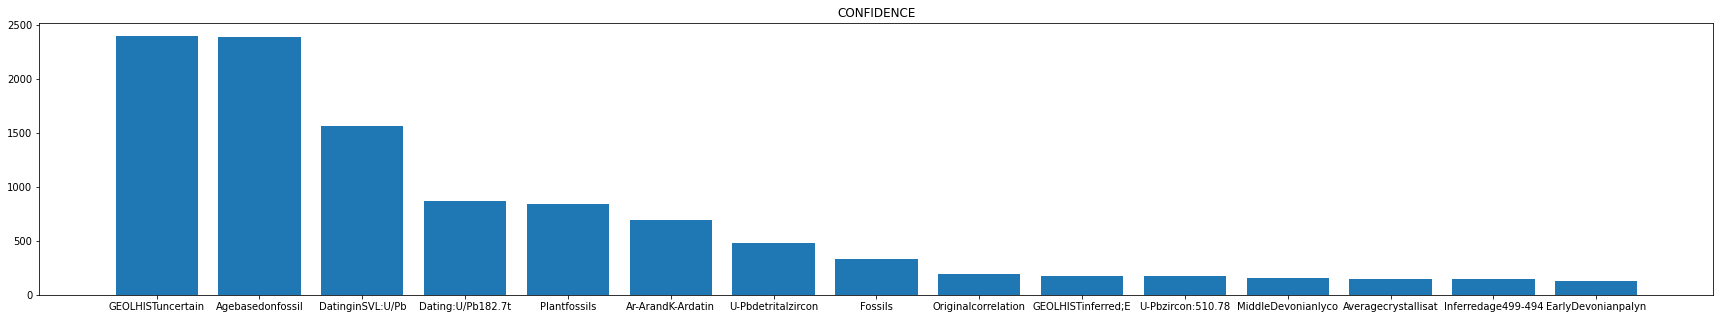

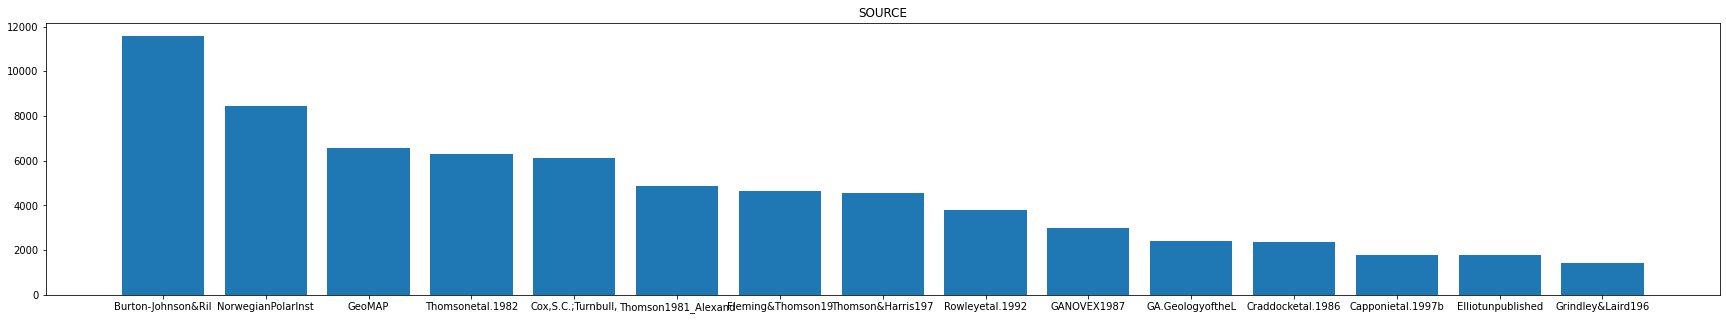

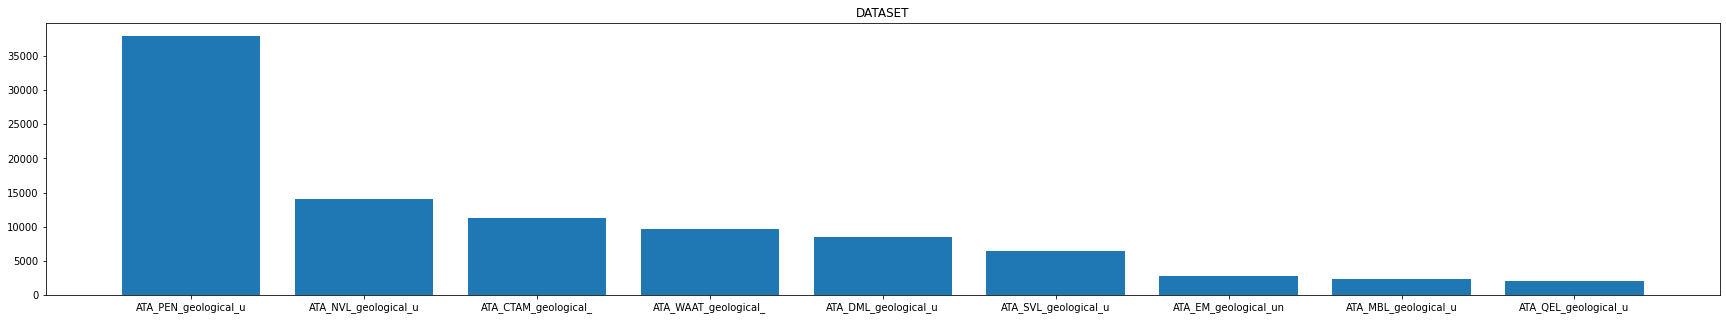

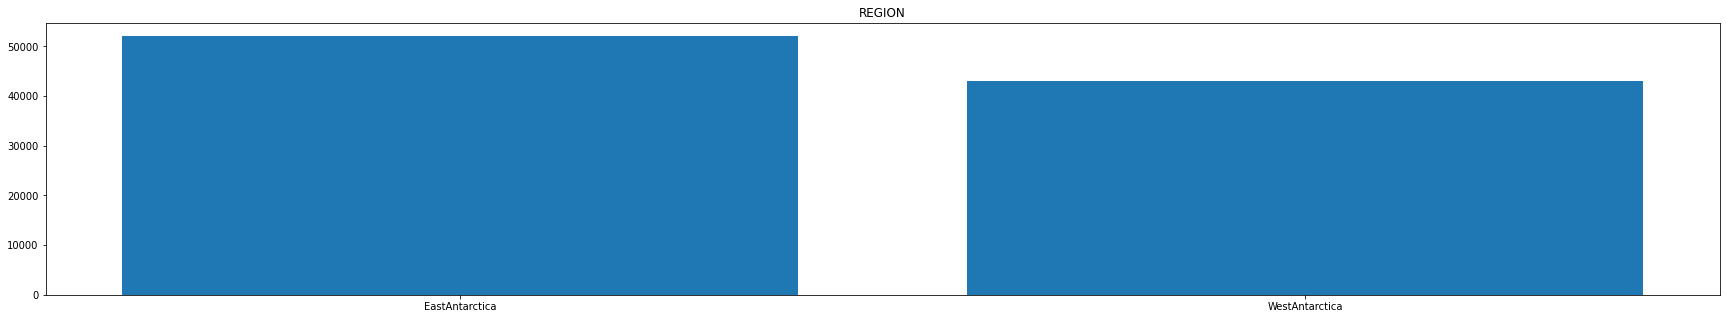

In [160]:
max_bars = 15
label_chars = 20
for i in range(len(value_counts)):
    fig, ax = plt.subplots(1,1, figsize=(30, 5))
        
    ax.set_title(value_count_cols[i])
    counts = len(value_counts[i])
    if counts >= max_bars:
        counts = max_bars 
    try:
        if value_count_cols[i][-4:] == "_URI":
            labels = [j[j.rindex("/") + 1:].replace(" ", "") for j in value_counts[i].index[:counts]]
        else:
            labels = [j[:label_chars].replace(" ", "") for j in value_counts[i].index[:counts]]
        ax.bar(labels, value_counts[i][:counts])
    except KeyError:
        print(counts, value_count_cols[i])
    fig.show()